In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_3pt_shooting = '../Data/nba_3pt_progressions_all_players.json'
with open(file_3pt_shooting, 'r') as f:
    data_3pt_shooting = json.load(f)
    f.close()

In [3]:
print(data_3pt_shooting[0])

{'name': 'Álex Abrines', 'url': 'https://www.basketball-reference.com/players/a/abrinal01.html', 'row_data': [{'age': '23', 'fg3': '94', 'fg3a': '247', 'fg3_pct': '.381'}, {'age': '24', 'fg3': '84', 'fg3a': '221', 'fg3_pct': '.380'}, {'age': '25', 'fg3': '41', 'fg3a': '127', 'fg3_pct': '.323'}]}


In [4]:
## Need to create a dataframe with the following columns
##  name                              - will be the 'units' value for sns.lineplot
##  season, as a zero'd out age value - will be the x axis
##  fg3
##  fg3a
##  fg3_pct                           - will be the y axis

## To Do:
##  [x] fix the issue with multiple rows when a player was on more than 1 team in a single season
##  [ ] don't include players with only 1 entry. Could be something to fix on the previous stage

records_3pt_shooting = []
for row in data_3pt_shooting:
    #print (row)
    name = row['name']
    min_age = min([int(x['age']) for x in row['row_data']])
    prev_age = 0
    for season in row['row_data']:
        year = int(season['age']) - min_age
        fg3 = float(season['fg3'].replace('<strong>','').replace('</strong>',''))
        fg3a = float(season['fg3a'].replace('<strong>','').replace('</strong>',''))
        fg3_pct = float(season['fg3_pct'].replace('<strong>','').replace('</strong>',''))
        if fg3a > 25 and prev_age!=season['age']:
            records_3pt_shooting.append({
                'name': name,
                'year': year,
                'fg3': fg3,
                'fg3a': fg3a,
                'fg3_pct': fg3_pct,
            })
        prev_age = season['age']

df_3pt_shooting = pd.DataFrame(records_3pt_shooting)

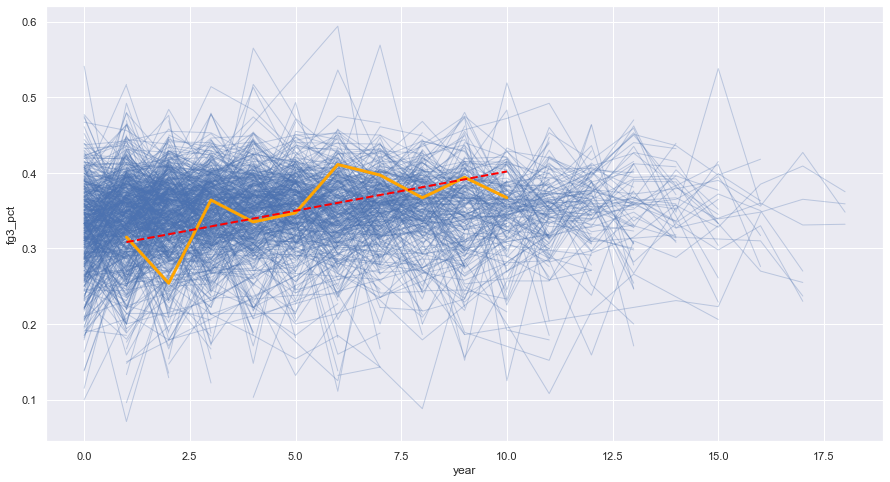

In [37]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.lineplot(
    data=df_3pt_shooting,
    x="year", y="fg3_pct", units="name",
    estimator=None, lw=1, alpha=0.3
)

player_highlight = 'Tobias Harris' #None
if player_highlight:
    df_3pt_shooting_player = df_3pt_shooting[df_3pt_shooting['name']==player_highlight]
    sns.lineplot(data=df_3pt_shooting_player,
        x="year", y="fg3_pct", units="name",
        estimator=None, lw=3, color='orange'
    )
    
    ## Plot the linear regression
    X = df_3pt_shooting_player['year'].values.reshape(-1, 1)
    Y = df_3pt_shooting_player['fg3_pct'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    #print (X, type(X))
    #print (Y_pred, type(Y_pred))
    sns.lineplot(x=X.reshape(1,-1)[0].tolist(), y=Y_pred.reshape(1,-1)[0].tolist(), 
                 lw=2, color='red', linestyle='--')

### Export the dataframe to csv for webapp use

In [8]:
df_3pt_shooting.to_csv('../Data/nba_3pt_progressions_dataframe.csv', index=False)

### Creating Linear Regressions For Each Player

To Do:
- [ ] Save the coefficients to a dataframe/list/json/...
- [ ] filter out the coefficients by a min/max boundry

In [9]:
from sklearn.linear_model import LinearRegression

In [44]:
def get_lin_reg_coef(df_3pt_shooting, player_name):
    df_player = df_3pt_shooting[df_3pt_shooting['name']==player_name]
    
    X = df_player['year'].values.reshape(-1, 1)
    Y = df_player['fg3_pct'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    ## Y_pred = linear_regressor.predict(X)  # make predictions
    
    return linear_regressor.coef_[0][0]

In [45]:
for player in list(set(list(df_3pt_shooting['name']))):
    
    print (player, get_lin_reg_coef(df_3pt_shooting, player))

Killian Tillie 0.011000000000000006
Gigi Datome 0.2709999999999999
Austin Daye 0.004057142857142861
Landry Fields -0.13699999999999998
Mo Williams 0.0034725274725274724
Jose Alvarado 0.0
Alex Len -0.09199999999999994
Norris Cole 0.005199999999999998
Miye Oni 0.0
Myles Turner -0.005285714285714277
Malcolm Hill 0.0
Andrea Bargnani -0.008416666666666664
Metta World Peace -0.0008661039150050938
Nik Stauskas 0.017400000000000002
Marcus Banks -0.002799999999999998
Jordan McLaughlin -0.03199999999999999
Shabazz Napier -0.006028571428571426
Jared Dudley 0.003456043956043954
Kevin Martin -5.454545454545506e-05
Jae'Sean Tate 0.004000000000000002
Gary Harris 0.010380952380952385
Rodions Kurucs 0.05199999999999998
Gary Clark 0.02450000000000002
Brandon Goodwin 0.022999999999999986
Romeo Langford 0.07799999999999999
Garrison Mathews -0.026499999999999992
Jalen Suggs 0.0
Aleksej Pokusevski 0.00899999999999995
Kenyon Martin Jr. -0.008000000000000004
Jared Sullinger 0.006499999999999975
Guerschon Yabu

Al Horford 0.002928571428571432
Aaron Nesmith -0.09999999999999995
Pau Gasol 0.028838509316770202
Dewayne Dedmon 0.006028571428571435
Jabari Brown 0.0
Landry Shamet -0.015
Goran Dragić -0.0030703296703296704
Kyle Weaver 0.0
Al-Farouq Aminu -0.002235764235764238
Tyus Jones 0.008000000000000002
Brandon Knight -0.005563063063063067
Bojan Bogdanović 0.005095238095238097
Rasual Butler -0.0021123474515434308
Joe Ingles 0.0010357142857142863
Thanasis Antetokounmpo 0.0
Max Strus 0.07199999999999994
Mardy Collins 0.07099999999999997
DeMarre Carroll -0.006297619047619046
Terrence Ross -0.005575757575757576
Anthony Randolph 0.0
Elfrid Payton -0.00478571428571429
DeShawn Stevenson -0.0011941176470588258
Luke Kornet -0.037599999999999995
Juancho Hernangómez -0.005085714285714287
Jonny Flynn -0.03199999999999999
Keyon Dooling 0.006716541353383458
James Harden -0.0020384615384615376
Devin Brown -0.007571428571428577
Gerald Wallace 0.0014545454545454495
Josh Smith 0.001516069788797061
Dionte Christmas

Isaiah Hartenstein 0.0
Terrance Ferguson -0.020500000000000015
Troy Williams 0.014000000000000005
John Konchar 0.037999999999999964
Abdel Nader 0.025000000000000005
Georgios Kalaitzakis 0.0
Nate Wolters 0.0
Ayo Dosunmu 0.0
Deividas Sirvydis 0.0
Jawad Williams -0.034000000000000016
Furkan Korkmaz -0.013800000000000015
Svi Mykhailiuk -0.01300000000000001
Donatas Motiejūnas -0.007899999999999992
Spencer Hawes 0.004923566878980896
Jarrett Culver -0.02199999999999998
Delonte West -0.0024166666666666672
Josh Hart -0.011600000000000003
Paul Watson -0.23799999999999988
Ronald Murray 0.01164285714285714
Isaiah Roby 0.14999999999999997
Tyler Cavanaugh 0.0
Aaron Harrison 0.0
Payton Pritchard 0.0010000000000000005
Brandon Boston Jr. 0.0
DaQuan Jeffries 0.0
Chris McCullough 0.0
Frank Ntilikina 0.024000000000000007
Aron Baynes -0.04099999999999997
Pascal Siakam 0.017599999999999998
Haywood Highsmith 0.0
Oshae Brissett -0.073
Dragan Bender 0.006799999999999988
Trevor Ariza 4.1758241758241155e-05
Chri

In [10]:
df_3pt_shooting_player.style

,name,year,fg3,fg3a,fg3_pct
1950,Tobias Harris,1,34.000000,108.000000,0.315000
1951,Tobias Harris,2,32.000000,126.000000,0.254000
1952,Tobias Harris,3,87.000000,239.000000,0.364000
1953,Tobias Harris,4,80.000000,239.000000,0.335000
1954,Tobias Harris,5,109.000000,314.000000,0.347000
1955,Tobias Harris,6,183.000000,445.000000,0.411000
1956,Tobias Harris,7,156.000000,393.000000,0.397000
1957,Tobias Harris,8,131.000000,357.000000,0.367000
1958,Tobias Harris,9,82.000000,208.000000,0.394000
1959,Tobias Harris,10,101.000000,275.000000,0.367000


In [13]:
X = df_3pt_shooting_player['year'].values.reshape(-1, 1)
Y = df_3pt_shooting_player['fg3_pct'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [38]:
#print (Y_pred)
print (linear_regressor.coef_)

[[0.01038182]]
